In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.integrate
import astropy.units as u
import GCRCatalogs

%matplotlib inline

In [2]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

## Extract DM haloes from the catalog in a given mass and redshift range. 

In [3]:
skysim_cat = GCRCatalogs.load_catalog('skysim5000_v1.1.1_small')
cosmo_ss  = skysim_cat.cosmology

In [4]:
print(cosmo_ss)
print(skysim_cat.sky_area)

FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.265, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=0.0448)
57.071968


In [5]:
# get list of halos in a given redshift and mass range 
mmin_extract = 1.e12 # Msun (M_fof)
zmin = 0.
zmax = 1.

dm_halos = skysim_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id',
                                             'baseDC2/sod_halo_mass','baseDC2/sod_halo_radius'],
                                            filters=[f'halo_mass > {mmin_extract}','is_central==True',
                                            f'redshift>{zmin}', f'redshift<{zmax}'])
N_cl = len(dm_halos['halo_mass'])
print(f'There are {N_cl} halos in this mass (Mfof) and redshift range')

There are 300879 halos in this mass (Mfof) and redshift range


#### Define a redshift and mass range
NB: SkySim5000 M200c masses are in units of Msun/h

In [6]:
tmp = dm_halos['baseDC2/sod_halo_mass']/cosmo_ss.h # sod_halo_mass = M200,c in Msun/h, needs conversion
mmin = 1.e14#np.min(tmp[tmp>0]) # Msun. Filtering are there are some negative masses in the table
mmax = 1.e15 # Msun

filt3 = tmp >= mmin
filt4 = tmp < mmax
filt = filt3 * filt4

data_m_ss = tmp[filt] # M200,c [Msun]
data_z_ss = dm_halos['redshift'][filt]


## Fill in NumCosmo dataset

In [7]:
#  Initializing the library objects, this must be called before 
#  any other library function.
#
Ncm.cfg_init ()

#  New homogeneous and isotropic cosmological model NcHICosmoDEXcdm 
#
#cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm")
cosmo = Nc.HICosmoLCDM()
#
#  New homogeneous and isotropic reionization object.
#
reion = Nc.HIReionCamb.new () 

#
#  New homogeneous and isotropic primordial object.
#
prim = Nc.HIPrimPowerLaw.new () 
#
# Adding submodels to the main cosmological model.
#
cosmo.add_submodel (reion)
cosmo.add_submodel (prim)

#
#  New cosmological distance objects optimizied to perform calculations
#  up to redshift 2.0.
#
dist = Nc.Distance.new (2.0)

#
# New transfer function 'NcTransferFuncEH' using the Einsenstein, Hu
# fitting formula.
#
tf = Nc.TransferFunc.new_from_name ("NcTransferFuncEH")
#
# New linear matter power spectrum object based of the EH transfer function.
# 
psml = Nc.PowspecMLTransfer.new (tf)
psml.require_kmin (1.0e-6)
psml.require_kmax (1.0e3)

#
# Apply a tophat filter to the psml object, set best output interval.
#
psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()

In [8]:
cosmo_ss.H0.value

71.0

In [9]:
#
#  Setting values for the cosmological model, those not set stay in the
#  default values. Remember to use the _orig_ version to set the original
#  parameters when a reparametrization is used.
#
cosmo.props.H0      = cosmo_ss.H0.value
cosmo.props.Omegab  = cosmo_ss.Ob0
cosmo.props.Omegac  = cosmo_ss.Odm0
cosmo.props.Omegax  = cosmo_ss.Ode0
old_amplitude = prim.props.ln10e10ASA
prim.props.ln10e10ASA = (cosmo_ss.sigma8 / psml.sigma_tophat_R (cosmo, 1.0e-7, 0.0, 8.0 / cosmo.h ()))**2 * old_amplitude
print(old_amplitude,prim.props.ln10e10ASA)

3.179 2.797232334275338


In [10]:
#
# New multiplicity function 'NcMultiplicityFuncTinkerMean'
#
mulf = Nc.MultiplicityFuncTinker.new ()
mulf.set_mdef (Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta (200.0)
#
# New mass function object using the objects defined above.
#
mf = Nc.HaloMassFunction.new (dist, psf, mulf)

#
# New Cluster Mass object using Log normal distribution
#
lnMobs_min = math.log (mmin)
lnMobs_max = math.log (mmax)

# cluster_m = Nc.ClusterMass.new_from_name ("NcClusterMassLnnormal{'lnMobs-min':<%20.15e>, 'lnMobs-max':<%20.15e>}" % (lnMobs_min, lnMobs_max))
cluster_m = Nc.ClusterMassNodist()
cluster_m.lnMobs_min = lnMobs_min
cluster_m.lnMobs_max = lnMobs_max
print(cluster_m.lnMobs_min, cluster_m.lnMobs_max)

32.23619130191664 34.538776394910684


In [11]:
#
# New Cluster Redshift object using a global gaussian distribution
#
#cluster_z = Nc.ClusterRedshift.new_from_name ("NcClusterPhotozGaussGlobal{'pz-min':<%20.15e>, 'pz-max':<%20.15e>, 'z-bias':<0.0>, 'sigma0':<0.03>}" % (zmin, zmax))
cluster_z = Nc.ClusterRedshiftNodist()
print(cluster_z.z_min, cluster_z.z_max)

0.0 1.0


In [12]:
#
# New Cluster abundance object that uses all objects above
#
cad = Nc.ClusterAbundance.new (mf, None)

#
# New NcmData object for number count calculations
#
ncdata = Nc.DataClusterNCount.new (cad)

#
#  Creating a new Modelset and set cosmo as the HICosmo model to be used
#  and cluster_m as the distribution of the mass-observable relation
#
mset = Ncm.MSet.new_array ([cosmo, cluster_z, cluster_m])

In [232]:
#
#  Setting values for the mass distribution model
#
# cluster_m.props.bias       = 0.0
# cluster_m.props.sigma      = 0.0

In [13]:
#
#  Printing the parameters used.
#
mset.pretty_log ()

In [ ]:
#
# Since ncdata is currently empty, run init_from_sampling
# using the objects above and an survey area of 300deg^2
#
#ncdata.init_from_sampling (mset, skysim_cat.sky_area * (math.pi / 180.0)**2, rng)

ncdata.set_n_z_obs (1)
ncdata.set_n_z_obs_params (0)
ncdata.set_n_M_obs (1)
ncdata.set_n_M_obs_params (0)

ncdata.set_lnM_true(Ncm.Vector.new_array(data_m_ss))
ncdata.set_z_true(Ncm.Vector.new_array(data_z_ss))
ncdata.true_data (True)

print('bou')
# if complains about missing observed quanitities, replicate true ones in matrix with one column
#ncdata.set_lnM_obs(Ncm.Vector.new_array(mass_vector))
#ncdata.set_lnz_obs(Ncm.Vector.new_array(z_vector))
ncdata.set_init(True)

#
# Save to a fits file
#
ncdata.catalog_save ("ca_data.fits", True)

In [236]:
cosmo.props.Omegac        = 0.2
cosmo.props.Omegac_fit    = True
cosmo.props.Omegab_fit    = False
prim.props.ln10e10ASA_fit = True

dset = Ncm.Dataset.new ()
dset.append_data (ncdata)

In [237]:
data = []
mass_vec = ncdata.get_lnM_true ()
z_vec = ncdata.get_z_true ()
for i in range (mass_vec.len ()):
    data.append ([z_vec.get (i), mass_vec.get (i)])

In [238]:
mass_vec

<NumCosmoMath.Vector object at 0x7f95edcf3a80 (NcmVector at 0x5642584b3d20)>

In [239]:
mass_vec.len()

1000

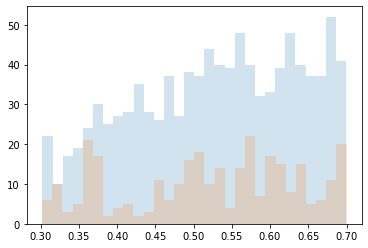

In [240]:
plt.hist(np.array(data).T[0], bins=30, alpha=0.2);
plt.hist(data_z_ss, bins=30, alpha=0.2);


Text(0.5, 0, 'log10(M)')

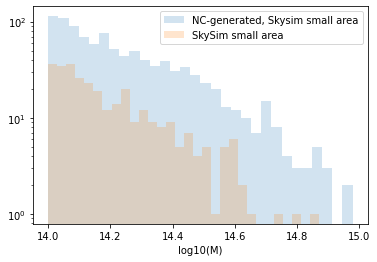

In [241]:
plt.hist(np.log10(np.exp(np.array(data).T[1])), bins=30, alpha=0.2, label='NC-generated, Skysim small area');
plt.hist(np.log10(data_m_ss),bins=30, alpha=0.2, label='SkySim small area')
plt.yscale('log')
plt.legend()
plt.xlabel('log10(M)')

In [163]:
#
# New likelihood object using dset
#
lh = Ncm.Likelihood.new (dset)

#
#  Creating a Fit object of type NLOPT using the fitting algorithm ln-neldermead to
#  fit the Modelset mset using the Likelihood lh and using a numerical differentiation
#  algorithm (NUMDIFF_FORWARD) to obtain the gradient (if needed).
#
fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

fit.run (Ncm.FitRunMsgs.FULL)

#
# Printing fitting informations.
#
fit.log_info ()

In [ ]:
#
# Setting single thread calculation.
#
Ncm.func_eval_set_max_threads (5)
Ncm.func_eval_log_pool_stats ()

#
# Additional functions
#
mfunc_oa = Ncm.ObjArray.new ()

mfunc_sigma8 = Ncm.MSetFuncList.new ("NcHICosmo:sigma8", psf)
mfunc_Omegam = Ncm.MSetFuncList.new ("NcHICosmo:Omega_m0", None)

mfunc_oa.add (mfunc_sigma8)
mfunc_oa.add (mfunc_Omegam)

print (mfunc_sigma8.eval0 (mset))
print (mfunc_Omegam.eval0 (mset))

#
# New Gaussian prior to provide the initial points for the chain.
# It was created with size 0 (number of parameters), but once 
# initialized with mset the correct size is assigned. 
#
# The initial sampler will use a diagonal covariance with the
# diagonal terms being the parameters scale set by each model.
#
init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0) #1

#
# Creates the ESMCMC walker object, this object is responsible
# for moving the walkers in each interation, the stretch move
# is affine invariant and therefore gives good results even for
# very correlated parametric space.
# 
sampler = 'apes'
#sampler  = 'stretch'
nwalkers = int (math.ceil (500)) #500
#ssize    = 1000000 #1000000

if sampler == 'apes':
  walker = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset.fparams_len ())
elif sampler == "stretch":
  walker = Ncm.FitESMCMCWalkerStretch.new (nwalkers, mset.fparams_len ())
#
# The methods below set the walk scale, which controls the size of the
# step done between two walkers and circumscribe the walkers inside
# the box defined by the parameters inside the mset object.
#
#walker.set_scale (3.0)
#walker.set_box_mset (mset)
#
# Initialize the ESMCMC object using the objects above. It will
# use 50 walkers, i.e., each point in the MCMC chain contains
# 50 points in the parametric space. Each step uses the last point
# in the chain (the last 50 parametric points) to calculate the
# proposal points.
#
esmcmc  = Ncm.FitESMCMC.new_funcs_array (fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa)

#
# These methods enable the auto-trim options on ESMCMC. This option 
# makes the sampler check the chains' health and trim any unnecessary 
# burn-in part. We set the number of divisions to 100 so we test the
# chains in blocks of n/100. The last method asserts that each 2min
# the catalog will be checked.
#
#esmcmc.set_auto_trim (True)
#esmcmc.set_auto_trim_div (100)
#esmcmc.set_max_runs_time (2.0 * 60.0)
#esmcmc.set_nthreads (4)
esmcmc.set_data_file ("Test_NC_%s_st_%d_true.fits" % (sampler, nwalkers))

#
# Running the esmcmc, it will first calculate 1000 points, after that
# it will estimate the error in the parameters mean. Using the current
# errors the algorithm tries to calculated how many extra steps are 
# necessary to obtain the required error `10^-3' in every parameters,
# and it will run such extra steps. It will repeat this procedure
# until it attains the required error in every parameter.
# 
#
esmcmc.start_run ()
#esmcmc.run (ssize / nwalkers)
#esmcmc.run (10)
esmcmc.run_lre (10, 1.e-3)
esmcmc.end_run ()

#
# Calculates the parameter means and covariance and set it into 
# the fit object and then print.
# 
esmcmc.mean_covar ()
fit.log_covar ()